# Introduction

<center><img src="https://i.imgur.com/9hLRsjZ.jpg" height=400></center>

This dataset was scraped from [nextspaceflight.com](https://nextspaceflight.com/launches/past/?page=1) and includes all the space missions since the beginning of Space Race between the USA and the Soviet Union in 1957!

### Install Package with Country Codes

In [1]:
pip install iso3166

### Upgrade Plotly

Run the cell below if you are working with Google Colab.

In [2]:
pip install --upgrade plotly

     |████████████████████████████████| 13.2MB 290kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


### Import Statements

In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# These might be helpful:
from iso3166 import countries
from datetime import datetime, timedelta

### Notebook Presentation

In [4]:
pd.options.display.float_format = '{:,.2f}'.format

### Load the Data

In [6]:
df_data = pd.read_csv('mission_launches.csv')

# Preliminary Data Exploration

* What is the shape of `df_data`? 
* How many rows and columns does it have?
* What are the column names?
* Are there any NaN values or duplicates?

In [7]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      4324 non-null   int64 
 1   Unnamed: 0.1    4324 non-null   int64 
 2   Organisation    4324 non-null   object
 3   Location        4324 non-null   object
 4   Date            4324 non-null   object
 5   Detail          4324 non-null   object
 6   Rocket_Status   4324 non-null   object
 7   Price           964 non-null    object
 8   Mission_Status  4324 non-null   object
dtypes: int64(2), object(7)
memory usage: 304.2+ KB


In [8]:
df_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Organisation', 'Location', 'Date',
       'Detail', 'Rocket_Status', 'Price', 'Mission_Status'],
      dtype='object')

In [9]:
df_data.shape

(4324, 9)

In [10]:
print(f"Missing values? {df_data.isna().values.any()}")
print(f"Duplicated values? {df_data.duplicated().values.any()}")

Missing values? True
Duplicated values? False


## Data Cleaning - Check for Missing Values and Duplicates

Consider removing columns containing junk data. 

In [11]:
## Dropping unnecessary columns 

## method n.1
del df_data["Unnamed: 0"]
## method n.2
df_data.drop(columns="Unnamed: 0.1", inplace=True)
df_data.head()

,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


In [12]:
## Data cleaning

print(f"Original dataframe shape: {df_data.shape}")

#duplicates
duplicates = df_data.duplicated().values.sum()

# Missing values
missing_values = df_data[df_data.isna().values] 
missing_values.sample(10)
print(f"Duplicates: {duplicates}")
print(f"Missing values: {missing_values.count()[0]} => they are only prices")


df_clean = df_data.drop_duplicates()
print(f"Dataframe shape excluding duplicates:{df_clean.shape}")


## missing values are only in Price column; won't be excluded from dataset



Original dataframe shape: (4324, 7)
Duplicates: 1
Missing values: 3360 => they are only prices
Dataframe shape excluding duplicates:(4323, 7)


## Descriptive Statistics

In [13]:
df_data.describe()

,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status
count,4324,4324,4324,4324,4324,964,4324
unique,56,137,4319,4278,2,56,4
top,RVSN USSR,"Site 31/6, Baikonur Cosmodrome, Kazakhstan","Wed Feb 07, 1990 01:33 UTC",Cosmos-3MRB (65MRB) | BOR-5 Shuttle,StatusRetired,450.0,Success
freq,1777,235,2,6,3534,136,3879


In [14]:
## Transforming date string to datetime

df_clean["Date"] = pd.to_datetime(df_clean["Date"], utc=True)
df_clean["Date"].sample(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1364   1997-09-25 14:34:00+00:00
Name: Date, dtype: datetime64[ns, UTC]

# Number of Launches per Company

Create a chart that shows the number of space mission launches by organisation.

In [15]:
df_org = df_clean.groupby("Organisation",as_index=False).agg({"Date": pd.Series.count})
df_org = df_org.sort_values("Date", ascending=True)
df_org.head()


,Organisation,Date
27,Khrunichev,1
53,Virgin Orbit,1
47,Starsem,1
44,Sandia,1
38,OneSpace,1


In [16]:
h_bar = px.bar(y=df_org["Organisation"], x=df_org["Date"], orientation="h", width=2000, height=1500, title="Launches by organisation")
h_bar.show()

# Number of Active versus Retired Rockets

How many rockets are active compared to those that are decomissioned? 

In [17]:
## Creating rocket column


rockets = df_clean["Detail"].str.split("|", expand=True)[0]
df_clean.insert(4, "Rocket", rockets)  
df_clean.head()


active_rockets_df = df_clean[df_clean['Rocket_Status'] == "StatusActive"].groupby("Rocket", as_index=False).agg({"Date": pd.Series.count})
list_active_rockets = active_rockets_df["Rocket"]
n_active_rockets = active_rockets_df.shape[0]
print(f"Number of active rockets: {n_active_rockets}")


retired_rockets_df = df_clean[df_clean['Rocket_Status'] == "StatusRetired"].groupby("Rocket", as_index=False).agg({"Date": pd.Series.count})
list_retired_rockets = retired_rockets_df["Rocket"] 
n_retired_rockets = retired_rockets_df.shape[0]
print(f"Number of retired rockets: {n_retired_rockets}")


tot_rocket_models = n_active_rockets + n_retired_rockets
print(f"Share of active rockets over total: {(n_active_rockets / tot_rocket_models)*100 :.2f}%")


Number of active rockets: 98
Number of retired rockets: 254
Share of active rockets over total: 27.84%


# Distribution of Mission Status

How many missions were successful?
How many missions failed?

In [18]:
## Launch success and failure statistics

print(f"Mission status: \n{df_clean['Mission_Status'].value_counts()}")

Mission status: 
Success              3878
Failure               339
Partial Failure       102
Prelaunch Failure       4
Name: Mission_Status, dtype: int64


In [19]:
# Total number of failures

failure_df = df_clean[df_clean['Mission_Status'] != "Success"]
n_failures = failure_df.shape[0] 
print(f"Total number of mission failure: {n_failures}")

Total number of mission failure: 445


# How Expensive are the Launches? 

Create a histogram and visualise the distribution. The price column is given in USD millions (careful of missing values). 

In [20]:
## Missing prices

price_nan = df_clean["Price"].isna().value_counts()[1]
print(f"Launches with unavailale price data: {price_nan}")


df_price = df_clean.dropna()
df_price.sample(10)

# convert prices stings to integers 
df_price["Price"] = df_price["Price"].astype(str).str.replace(",", "") 
df_price["Price"] = pd.to_numeric(df_price["Price"])


print(f"Dataframe dimensions with available prices: {df_price.shape}")

df_price.head()

Launches with unavailale price data: 3360
Dataframe dimensions with available prices: (963, 8)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Organisation,Location,Date,Detail,Rocket,Rocket_Status,Price,Mission_Status
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,Falcon 9 Block 5,StatusActive,50.00,Success
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,Long March 2D,StatusActive,29.75,Success
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,Proton-M/Briz-M,StatusActive,65.00,Success
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,Atlas V 541,StatusActive,145.00,Success
5,CASC,"LC-9, Taiyuan Satellite Launch Center, China",2020-07-25 03:13:00+00:00,"Long March 4B | Ziyuan-3 03, Apocalypse-10 & N...",Long March 4B,StatusActive,64.68,Success


In [21]:
px.histogram(df_price, x="Date", y="Price", nbins=100, title="Launches' costs")
             

# Use a Choropleth Map to Show the Number of Launches by Country

* Create a choropleth map using [the plotly documentation](https://plotly.com/python/choropleth-maps/)
* Experiment with [plotly's available colours](https://plotly.com/python/builtin-colorscales/). I quite like the sequential colour `matter` on this map. 
* You'll need to extract a `country` feature as well as change the country names that no longer exist.

Wrangle the Country Names

You'll need to use a 3 letter country code for each country. You might have to change some country names.

* Russia is the Russian Federation
* New Mexico should be USA
* Yellow Sea refers to China
* Shahrud Missile Test Site should be Iran
* Pacific Missile Range Facility should be USA
* Barents Sea should be Russian Federation
* Gran Canaria should be USA


You can use the iso3166 package to convert the country names to Alpha3 format.

In [22]:
## Update dataset with nations

import iso3166
from iso3166 import countries

location_country = df_clean["Location"].str.split(", ")
new_usa = ["Gran Canaria", "Pacific Missile Range Facility", "New Mexico", "Pacific Ocean"]
new_russian_fed = ["Barents Sea", "Russia", "Kazakhstan"]

country_list = []
for i in location_country:
  if i[-1] in new_usa:
    i[-1] = "USA"
  elif i[-1] == "Shahrud Missile Test Site":
    i[-1] = "Iran"
  elif i[-1] in new_russian_fed:
    i[-1] = "Russian Federation"
  elif i[-1] == "Yellow Sea":
    i[-1] = "China"
  elif i[-1] == "Kenya":
    i[-1] = "Italy"  #Malindi (Kenya) was Italy's spaceport
  country_list.append(i[-1])
country_list

df_clean.head()

,Organisation,Location,Date,Detail,Rocket,Rocket_Status,Price,Mission_Status
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,Falcon 9 Block 5,StatusActive,50.0,Success
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,Long March 2D,StatusActive,29.75,Success
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,Starship Prototype,StatusActive,NaN,Success
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,Proton-M/Briz-M,StatusActive,65.0,Success
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,Atlas V 541,StatusActive,145.0,Success


In [23]:
# df_clean.drop("Nation", axis=1, inplace=True)
df_clean.insert(2, "Nation", country_list)
all_countries = df_clean["Nation"].unique()
# print(all_countries)

df_clean.head()

,Organisation,Location,Nation,Date,Detail,Rocket,Rocket_Status,Price,Mission_Status
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",USA,2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,Falcon 9 Block 5,StatusActive,50.0,Success
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",China,2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,Long March 2D,StatusActive,29.75,Success
2,SpaceX,"Pad A, Boca Chica, Texas, USA",USA,2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,Starship Prototype,StatusActive,NaN,Success
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",Russian Federation,2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,Proton-M/Briz-M,StatusActive,65.0,Success
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",USA,2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,Atlas V 541,StatusActive,145.0,Success


In [24]:
## Launches by nation

launches_per_country = df_clean.groupby(["Nation"], as_index=False).agg({"Date":pd.Series.count})
launches_per_country.rename(columns={"Date": "Launches"}, inplace=True)
print(launches_per_country.head())


map = px.choropleth(launches_per_country, 
                    locations="Nation", 
                    color="Launches",
                    hover_name="Nation", 
                    locationmode="country names",
                    color_continuous_scale=px.colors.sequential.matter,
                    title="Launches by nation")

map.update_layout(coloraxis_showscale=True)
map.show()

      Nation  Launches
0  Australia         6
1     Brazil         3
2      China       268
3     France       303
4      India        76


# Use a Choropleth Map to Show the Number of Failures by Country


In [25]:
# Update dataset with counting all kind of failures in one column 

failure = []
for i in df_clean["Mission_Status"]:
  if i != "Success":
    failure.append("failure")
  else:
    failure.append("success")
df_clean["Launch_outcome"] = failure
df_clean.sample(5)

mission_country_df = df_clean[df_clean["Launch_outcome"] == "failure"] 
mission_country = mission_country_df.groupby(["Nation", "Launch_outcome"], as_index=False).agg({"Date": pd.Series.count})
mission_country.rename(columns={"Date": "Launches"}, inplace=True)
mission_country

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Nation,Launch_outcome,Launches
0,Australia,failure,3
1,Brazil,failure,3
2,China,failure,25
3,France,failure,18
4,India,failure,13
5,Iran,failure,9
6,Israel,failure,2
7,Japan,failure,13
8,New Zealand,failure,2
9,North Korea,failure,3


In [26]:
world_map = px.choropleth(mission_country,
                          locations='Nation',
                          color="Launches",
                          locationmode="country names",
                          color_continuous_scale=px.colors.sequential.matter,
                          title="Map launch failures by country")
world_map.show()

# Create a Plotly Sunburst Chart of the countries, organisations, and mission status. 

In [27]:
## Dataset

df_sunburst = df_clean.groupby(["Nation", "Organisation", "Mission_Status"], as_index=False).agg({"Date": pd.Series.count})
df_sunburst.rename(columns={"Date": "Launches"}, inplace=True)

df_sunburst.sample(5)

,Nation,Organisation,Mission_Status,Launches
45,Japan,MHI,Success,80
14,China,Landspace,Failure,1
75,Russian Federation,VKS RF,Failure,7
103,USA,NASA,Success,186
108,USA,Sea Launch,Failure,3


In [88]:
## Graph

sunburst = px.sunburst(data_frame=df_sunburst,
                       path=["Nation", "Organisation", "Mission_Status"],
                       values="Launches", title="Launches by countries, organisations, and mission status",
                       height=800)
sunburst.show()

# Analyse the Total Amount of Money Spent by Organisation on Space Missions

In [29]:
# df_clean.sample(5)

In [30]:
## Define dataframe with available price data 

# print(df_price.info())


df_tot_money = df_price.groupby("Organisation", as_index=False).agg({"Price": pd.Series.sum})
df_tot_money.rename(columns={"Price": "Tot_cost"}, inplace=True)
df_tot_money = df_tot_money.sort_values("Tot_cost", ascending=False)
df_tot_money

,Organisation,Tot_cost
14,NASA,"76,280.00"
0,Arianespace,"16,345.00"
21,ULA,"14,798.00"
16,RVSN USSR,"10,000.00"
2,CASC,"6,310.51"
20,SpaceX,"5,444.00"
15,Northrop,"3,930.00"
12,MHI,"3,532.50"
8,ISRO,"2,177.00"
22,US Air Force,"1,550.92"


In [31]:
total_money_spent = df_tot_money["Tot_cost"].sum()
print(f"Total amount spent since the Space Race: ${total_money_spent/1000:.2f}B")

Total amount spent since the Space Race: $148.23B


# Analyse the Amount of Money Spent by Organisation per Launch

In [32]:
## Determine companies' avg cost per launch

# df_price.info()

launches_per_org = df_price.groupby(["Organisation"], as_index=False).agg({"Date": pd.Series.count, "Price": pd.Series.sum})
launches_per_org.rename(columns={"Price":"Tot_cost", "Date": "Launches"}, inplace=True)


launches_per_org["Cost_per_launch"] = launches_per_org["Tot_cost"] / launches_per_org["Launches"] 
launches_per_org.head()


,Organisation,Launches,Tot_cost,Cost_per_launch
0,Arianespace,96,"16,345.00",170.26
1,Boeing,7,"1,241.00",177.29
2,CASC,157,"6,310.51",40.19
3,EER,1,20.00,20.00
4,ESA,1,37.00,37.00


In [33]:
## Chart

launches_per_org = launches_per_org.sort_values("Cost_per_launch", ascending=True)
launches_per_org.tail()


h_bar = px.bar(launches_per_org, y="Organisation", x="Cost_per_launch", orientation="h", title="Money spent by Organisations in $k", width=2000, height=1000)
h_bar.show()


# df_clean[df_clean["Organisation"] == "RVSN USSR"].shape[0]

## RVSN USSR has attempted 1777 launches, price data just on 2 of them


# Chart the Number of Launches per Year

In [34]:
## Launches per year

df_launches_per_year = df_clean
df_launches_per_year["Year"] = df_clean["Date"].dt.year 
launches_per_year = df_launches_per_year.groupby("Year", as_index=False).agg({"Date": pd.Series.count})
launches_per_year.rename(columns={"Date": "Launches"}, inplace=True)
launches_per_year.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Year,Launches
0,1957,3
1,1958,28
2,1959,20
3,1960,39
4,1961,52


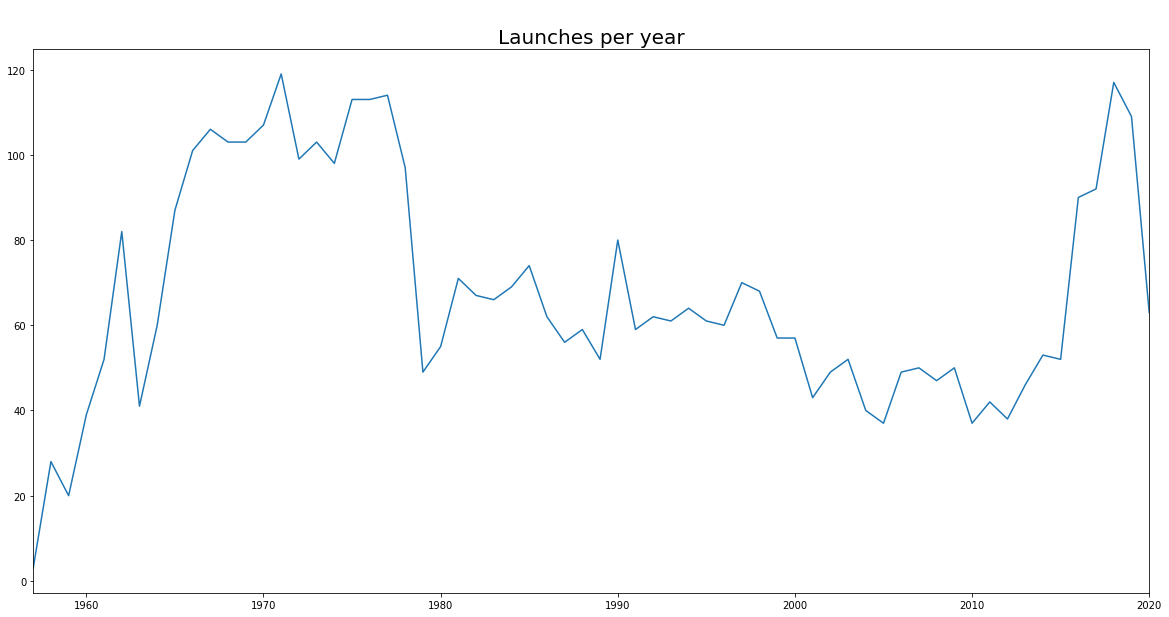

In [35]:
## Chart

plt.figure(figsize=(20, 10))
plt.title("\nLaunches per year", fontsize=20)

plt.xlim(1957, 2020)

chart = plt.plot(launches_per_year["Year"],
                 launches_per_year["Launches"])



# Chart the Number of Launches Month-on-Month until the Present

Which month has seen the highest number of launches in all time? Superimpose a rolling average on the month on month time series chart. 

In [36]:

df_launches_per_year["Month"] = df_clean["Date"].dt.month 
launches_per_year = df_launches_per_year.groupby(["Year", "Month"], as_index=False).agg({"Date": pd.Series.count})
launches_per_year.rename(columns={"Date": "Launches"}, inplace=True)
launches_per_year = launches_per_year.sort_values("Year", ascending=False)
launches_per_year.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Year,Month,Launches
746,2020,8,3
745,2020,7,14
744,2020,6,7
743,2020,5,9
742,2020,4,5


In [37]:
## Graph

h_bar = px.bar(launches_per_year, x="Launches", y="Year", color="Month", orientation="h", width=1000, height=2000 )


h_bar.show()

# Launches per Month: Which months are most popular and least popular for launches?

Some months have better weather than others. Which time of year seems to be best for space missions?

In [38]:
# Launches per month

df_launches_per_month = df_clean
df_launches_per_month["Month"] = df_clean["Date"].dt.month
launches_per_month = df_launches_per_month.groupby("Month",as_index=False).agg({"Date": pd.Series.count})
launches_per_month.rename(columns={"Date": "Launches"}, inplace=True)

launches_per_month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Month,Launches
0,1,268
1,2,336
2,3,353
3,4,383
4,5,326
5,6,402
6,7,351
7,8,373
8,9,365
9,10,381


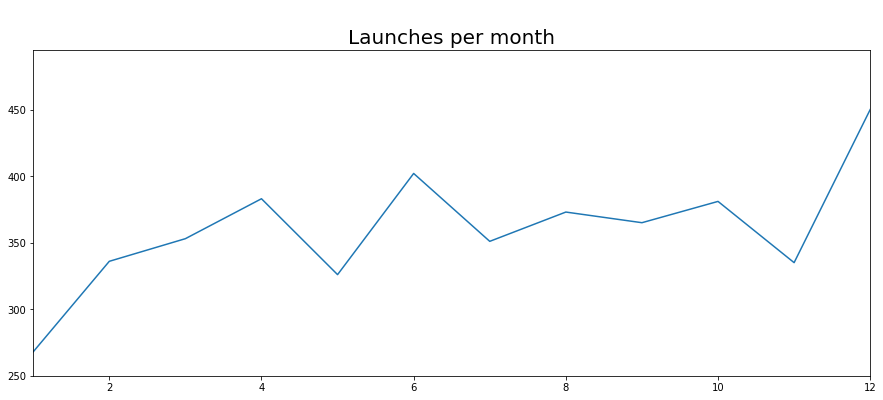

In [39]:
## Chart

plt.figure(figsize=(15, 6))
plt.title("\nLaunches per month", fontsize=20)

plt.ylim(250, launches_per_month["Launches"].max()*1.1)
plt.xlim(1, 12)

plt.plot(launches_per_month["Month"],
         launches_per_month["Launches"])


# How has the Launch Price varied Over Time? 

Create a line chart that shows the average price of rocket launches over time. 

In [40]:
## Dataframe launch cost over time

df_price["Year"] = df_price["Date"].dt.year 
cost_over_time = df_price.groupby(["Year"], as_index=False).agg({"Price": pd.Series.sum, "Date": pd.Series.count})
cost_over_time.rename(columns={"Date": "Launches"}, inplace=True)
cost_over_time["Price_per_launch"] = cost_over_time["Price"] / cost_over_time["Launches"]
cost_over_time.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Year,Price,Launches,Price_per_launch
0,1964,126.46,2,63.23
1,1965,126.46,2,63.23
2,1966,177.00,3,59.00
3,1967,"1,573.00",8,196.62
4,1968,"2,792.00",10,279.20


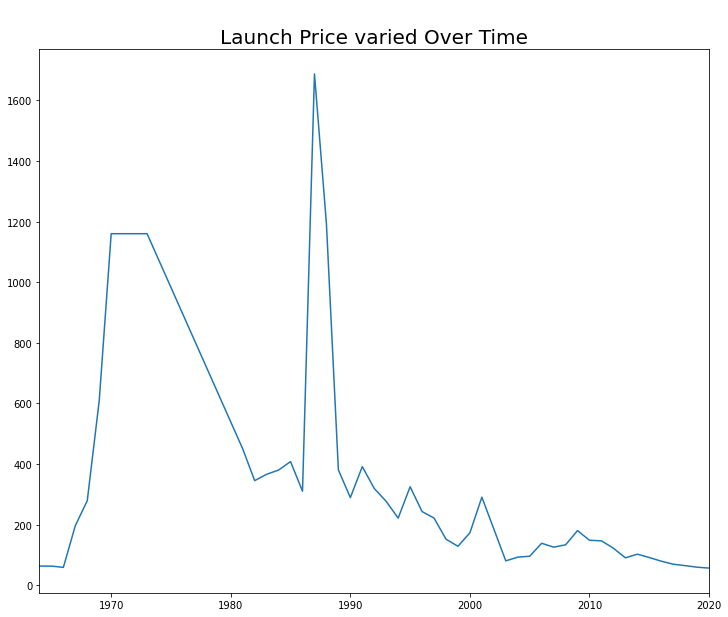

In [41]:
## Chart

plt.figure(figsize=(12, 10))
plt.title("\nLaunch Price varied Over Time", fontsize=20)
plt.xlim(cost_over_time["Year"].min(), cost_over_time["Year"].max())

chart = plt.plot(cost_over_time["Year"],
                 cost_over_time["Price_per_launch"])



# Investigate the Number of Launches over Time by the Top 10 Organisations. 

How has the dominance of launches changed over time between the different players? 

In [42]:
# Organisation launches year by year


org_launches = df_clean.groupby(["Organisation", "Year"], as_index=False).agg({"Date": pd.Series.count})
org_launches.rename(columns={"Date": "Tot_launches"}, inplace=True) 

org_launches.head()


,Organisation,Year,Tot_launches
0,AEB,1997,1
1,AEB,1999,1
2,AEB,2003,1
3,AMBA,1958,7
4,AMBA,1967,1


In [66]:
## Top 10 organisations by lauches


tot_org_launches = df_clean.groupby(["Organisation"], as_index=False).agg({"Date": pd.Series.count})
tot_org_launches = tot_org_launches.sort_values("Date", ascending=False)
tot_org_launches.rename(columns={"Date": "Tot_org_launches"}, inplace=True)


top10_org = tot_org_launches[:10]
top10_org.head(10)



,Organisation,Tot_org_launches
40,RVSN USSR,1777
3,Arianespace,279
17,General Dynamics,251
7,CASC,250
35,NASA,203
52,VKS RF,201
49,US Air Force,161
48,ULA,140
6,Boeing,136
34,Martin Marietta,114


# Cold War Space Race: USA vs USSR

The cold war lasted from the start of the dataset up until 1991. 

In [67]:
## USA vs URSS


df_cold_war_usa = df_clean.loc[(df_clean["Nation"] == "USA")&(df_clean["Year"] < 1991)]
print(f"number of USA launches during Cold War: {len(df_cold_war_usa)}")

df_cold_war_rus = df_clean.loc[(df_clean["Nation"] == "Russian Federation")&(df_clean["Year"] < 1991)]
print(f"number of URSS launches during Cold War: {len(df_cold_war_rus)}")



number of USA launches during Cold War: 644
number of URSS launches during Cold War: 1741


In [68]:
# df_cold_war = pd.concat([df_cold_war_usa, df_cold_war_urss])
# df_cold_war.sample(10)

# # CUT THE DF
# df_cold_war.drop(["Organisation", "Location", "Detail", "Rocket_Status", "ISO"], inplace=True, axis=1)
# df_cold_war["Cold_War_block"] = np.where(df_cold_war["Nation"] != "USA", "URSS", "USA")


## Create a Plotly Pie Chart comparing the total number of launches of the USSR and the USA

Hint: Remember to include former Soviet Republics like Kazakhstan when analysing the total number of launches. 

In [69]:
the_values = [len(df_cold_war_usa), len(df_cold_war_rus)]
the_labels = [df_cold_war_usa["Nation"].unique(), df_cold_war_rus["Nation"].unique()]

fig = px.pie(labels=the_labels, 
             values=the_values,
             names=the_labels,
             hover_name=the_labels)
fig.update_traces(title="USA vs URSS - total launches during Cold War", textposition="inside", textinfo="percent+label")


fig.show()

## Create a Chart that Shows the Total Number of Launches Year-On-Year by the Two Superpowers

In [70]:
## Create superpowers' dataframe

superpowers = {"USA", "Russian Federation"}

superpowers_df = df_clean[df_clean["Nation"].isin(superpowers)]
superpowers_df = superpowers_df.groupby(["Year", "Nation"], as_index=False).agg({"Date": pd.Series.count})
superpowers_df.rename(columns={"Date": "Launches"}, inplace=True)

superpowers_df



,Year,Nation,Launches
0,1957,Russian Federation,2
1,1957,USA,1
2,1958,Russian Federation,5
3,1958,USA,23
4,1959,Russian Federation,4
...,...,...,...
123,2018,USA,34
124,2019,Russian Federation,22
125,2019,USA,27
126,2020,Russian Federation,9


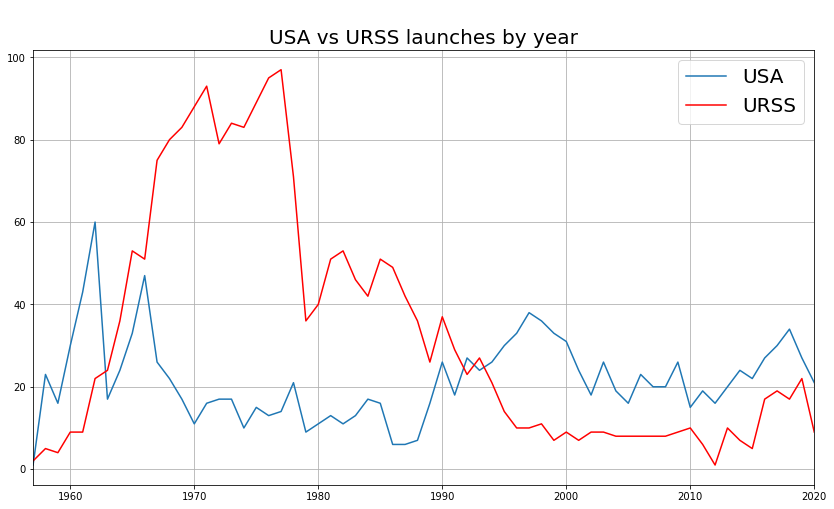

In [71]:
## Chart


usa_launches = superpowers_df[superpowers_df["Nation"] == "USA"] 
russia_launches = superpowers_df[superpowers_df["Nation"] == "Russian Federation"]


plt.figure(figsize=(14, 8))
plt.title("\nUSA vs URSS launches by year", fontsize=20)
plt.grid("darklines")


plt.plot(usa_launches["Year"], usa_launches["Launches"], label="USA")
plt.plot(russia_launches["Year"], russia_launches["Launches"], label="URSS", color="red")

plt.xlim(1957, 2020)
plt.legend(fontsize=20)



## Chart the Total Number of Mission Failures Year on Year.

In [72]:
## Create failure dataframe

df_failures = df_clean.groupby(["Year", "Launch_outcome"], as_index=False).agg({"Date": pd.Series.count})
failures_per_year = df_failures.loc[df_failures["Launch_outcome"] == "failure"]
failures_per_year.rename(columns={"Date": "Launches"}, inplace=True)
failures_per_year.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Year,Launch_outcome,Launches
0,1957,failure,1
2,1958,failure,22
4,1959,failure,12
6,1960,failure,20
8,1961,failure,20


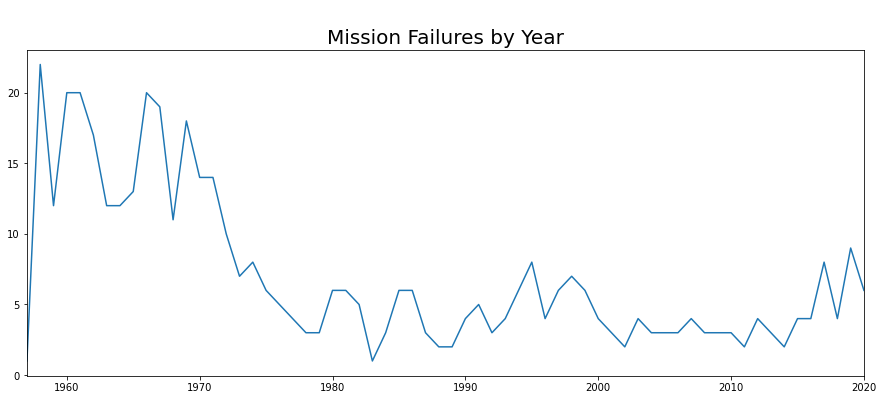

In [73]:
## Chart

plt.figure(figsize=(15, 6))

plt.title("\nMission Failures by Year", fontsize=20)
plt.xlim(1957, 2020)

plt.plot(failures_per_year["Year"], failures_per_year["Launches"])


## Investigate the Percentage of Failures over Time

Did failures go up or down over time? Did the countries get better at minimising risk and improving their chances of success over time? 

In [74]:
## Create dataframe with % launches failure

a = df_clean[["Nation", "Launch_outcome", "Date", "Year"]]
b = df_clean.groupby(["Year", "Nation", "Launch_outcome"], as_index=False).agg({"Date": pd.Series.count})

launch_nation_year = a.groupby(["Year", "Nation"], as_index=False).agg({"Date": pd.Series.count})
launch_nation_year = launch_nation_year.rename(columns={"Date": "Tot_nation_launches_year"})
failures = b[b.Launch_outcome == "failure"]
failures.head()
merged_country_failure = pd.merge(failures, launch_nation_year, on=["Nation", "Year"])
merged_country_failure["pct_failure"] = merged_country_failure["Date"] / merged_country_failure["Tot_nation_launches_year"] *100
merged_country_failure.rename(columns={"Date": "Launches"})

,Year,Nation,Launch_outcome,Launches,Tot_nation_launches_year,pct_failure
0,1957,USA,failure,1,1,100.00
1,1958,Russian Federation,failure,4,5,80.00
2,1958,USA,failure,18,23,78.26
3,1959,Russian Federation,failure,2,4,50.00
4,1959,USA,failure,10,16,62.50
...,...,...,...,...,...,...
175,2019,USA,failure,3,27,11.11
176,2020,China,failure,3,22,13.64
177,2020,Iran,failure,1,2,50.00
178,2020,New Zealand,failure,1,3,33.33


# For Every Year Show which Country was in the Lead in terms of Total Number of Launches up to and including including 2020)

Do the results change if we only look at the number of successful launches? 

In [75]:
## Leading nations for total launches *ATTEMPTS - year by year

tot_launch_year = df_clean.groupby("Year", as_index=False).agg({"Date": pd.Series.count})
g = df_clean.groupby(["Year", "Nation"], as_index=False).agg({"Date": pd.Series.count})
nations = g["Nation"].unique()
years = g["Year"].unique()


## add total launches per year to the df
merge_country_lead = pd.merge(g, tot_launch_year, on=["Year"])
merge_country_lead.rename(columns={"Date_x": "Nation_year_launches", "Date_y": "Tot_year_launches"}, inplace=True)


## calculate share of total year launches by nation
merge_country_lead["Nation_share_year_launches"] = round(merge_country_lead["Nation_year_launches"] / merge_country_lead["Tot_year_launches"], 2) 
merge_country_lead

## create a dictionary, appending values year by year
leading_nations = {}
for year in years:
  a = merge_country_lead[merge_country_lead["Year"] == year]
  b = a.loc[a["Nation_share_year_launches"].idxmax()]

  the_year = b["Year"]
  the_nation = b["Nation"]
  the_share = b["Nation_share_year_launches"]
  

  leading_nations[the_year] = {"Attempts": {"nation": the_nation, "share": f"{the_share *100:.2f}%"}}
                              #  "Success": {"nation": }
                               # with dict
  # leading_nations[the_year] = [the_nation, f"{the_share *100}%"]  # with list
leading_nations




{1957: {'Attempts': {'nation': 'Russian Federation', 'share': '67.00%'}},
 1958: {'Attempts': {'nation': 'USA', 'share': '82.00%'}},
 1959: {'Attempts': {'nation': 'USA', 'share': '80.00%'}},
 1960: {'Attempts': {'nation': 'USA', 'share': '77.00%'}},
 1961: {'Attempts': {'nation': 'USA', 'share': '83.00%'}},
 1962: {'Attempts': {'nation': 'USA', 'share': '73.00%'}},
 1963: {'Attempts': {'nation': 'Russian Federation', 'share': '59.00%'}},
 1964: {'Attempts': {'nation': 'Russian Federation', 'share': '60.00%'}},
 1965: {'Attempts': {'nation': 'Russian Federation', 'share': '61.00%'}},
 1966: {'Attempts': {'nation': 'Russian Federation', 'share': '50.00%'}},
 1967: {'Attempts': {'nation': 'Russian Federation', 'share': '71.00%'}},
 1968: {'Attempts': {'nation': 'Russian Federation', 'share': '78.00%'}},
 1969: {'Attempts': {'nation': 'Russian Federation', 'share': '81.00%'}},
 1970: {'Attempts': {'nation': 'Russian Federation', 'share': '82.00%'}},
 1971: {'Attempts': {'nation': 'Russian

In [76]:
## Leading nations for total launches *SUCCESS - year by year


h = df_clean[df_clean["Launch_outcome"] == "success"]
tot_success_year = h.groupby("Year", as_index=False).agg({"Date": pd.Series.count})
h = h.groupby(["Year", "Nation"], as_index=False).agg({"Date": pd.Series.count})


nations = h["Nation"].unique()
years = h["Year"].unique()

## merge df
merged_df = pd.merge(h, tot_success_year, on="Year")
merged_df.rename(columns={"Date_x":"Nation_succ_year", "Date_y": "Tot_succ_year"}, inplace=True)
merged_df["Nation_share_succ_year"] = round(merged_df["Nation_succ_year"] / merged_df["Tot_succ_year"], 2)
# print(merged_df)

## append success dictionary to dictionary "leading_nations" 
for year in years:
  a = merged_df[merged_df["Year"] == year]
  b = a.loc[a["Nation_share_succ_year"].idxmax()]

  succ_year = b["Year"]
  succ_nation = b["Nation"]
  succ_share = b["Nation_share_succ_year"]

  leading_nations[succ_year].update({"Success": {"nation": succ_nation, "share": f"{succ_share *100:.2f}%"}})
                      
                               
leading_nations



{1957: {'Attempts': {'nation': 'Russian Federation', 'share': '67.00%'},
  'Success': {'nation': 'Russian Federation', 'share': '100.00%'}},
 1958: {'Attempts': {'nation': 'USA', 'share': '82.00%'},
  'Success': {'nation': 'USA', 'share': '83.00%'}},
 1959: {'Attempts': {'nation': 'USA', 'share': '80.00%'},
  'Success': {'nation': 'USA', 'share': '75.00%'}},
 1960: {'Attempts': {'nation': 'USA', 'share': '77.00%'},
  'Success': {'nation': 'USA', 'share': '84.00%'}},
 1961: {'Attempts': {'nation': 'USA', 'share': '83.00%'},
  'Success': {'nation': 'USA', 'share': '84.00%'}},
 1962: {'Attempts': {'nation': 'USA', 'share': '73.00%'},
  'Success': {'nation': 'USA', 'share': '77.00%'}},
 1963: {'Attempts': {'nation': 'Russian Federation', 'share': '59.00%'},
  'Success': {'nation': 'Russian Federation', 'share': '55.00%'}},
 1964: {'Attempts': {'nation': 'Russian Federation', 'share': '60.00%'},
  'Success': {'nation': 'Russian Federation', 'share': '60.00%'}},
 1965: {'Attempts': {'nation'

# Create a Year-on-Year Chart Showing the Organisation Doing the Most Number of Launches

Which organisation was dominant in the 1970s and 1980s? Which organisation was dominant in 2018, 2019 and 2020? 

In [77]:
## Leading organisations for total launches *SUCCESS - year by year


z = df_clean.groupby(["Year", "Organisation"], as_index=False).agg({"Date": pd.Series.count})
# z = z.sort_values("Year", ascending=False)


## merge df
merged_df = pd.merge(z, tot_launch_year, on="Year")
merged_df.rename(columns={"Date_x":"Org_launch_year", "Date_y": "Tot_launch_year"}, inplace=True)
merged_df["Org_share_succ_year"] = round(merged_df["Org_launch_year"] / merged_df["Tot_launch_year"], 2)
# print(merged_df)


## plot each leading organisation year by year: 
orgs = z["Organisation"].unique()
years = z["Year"].unique()
leading_orgs = []

# merged_df = merged_df.sort_values("Year", ascending=False)
for year in years:
  a = merged_df[merged_df["Year"] == year]
  b = a.loc[a["Org_share_succ_year"].idxmax()]

  the_year = b["Year"]
  the_org = b["Organisation"]
  the_share = b["Org_share_succ_year"]
  the_launches = b["Org_launch_year"] 

  leading_orgs.append({"year": the_year,"org": the_org, "launches": the_launches, "tot_share": f"{the_share *100:.2f}%"})
leading_orgs



[{'launches': 2, 'org': 'RVSN USSR', 'tot_share': '67.00%', 'year': 1957},
 {'launches': 12, 'org': 'US Navy', 'tot_share': '43.00%', 'year': 1958},
 {'launches': 10, 'org': 'US Air Force', 'tot_share': '50.00%', 'year': 1959},
 {'launches': 21, 'org': 'US Air Force', 'tot_share': '54.00%', 'year': 1960},
 {'launches': 23, 'org': 'US Air Force', 'tot_share': '44.00%', 'year': 1961},
 {'launches': 41, 'org': 'US Air Force', 'tot_share': '50.00%', 'year': 1962},
 {'launches': 24, 'org': 'RVSN USSR', 'tot_share': '59.00%', 'year': 1963},
 {'launches': 36, 'org': 'RVSN USSR', 'tot_share': '60.00%', 'year': 1964},
 {'launches': 53, 'org': 'RVSN USSR', 'tot_share': '61.00%', 'year': 1965},
 {'launches': 51, 'org': 'RVSN USSR', 'tot_share': '50.00%', 'year': 1966},
 {'launches': 74, 'org': 'RVSN USSR', 'tot_share': '70.00%', 'year': 1967},
 {'launches': 79, 'org': 'RVSN USSR', 'tot_share': '77.00%', 'year': 1968},
 {'launches': 82, 'org': 'RVSN USSR', 'tot_share': '80.00%', 'year': 1969},
 {'

In [78]:
## Chart



fig = px.bar(leading_orgs, y="year", x="launches", orientation="h", width=1500, height=1500, color="org")


fig.update_layout(title="\nLeading Organisation by year",
                  font=dict(family="Courier", size=25, color="black"))


